Link Dataset

-https://www.kaggle.com/datasets/balabaskar/silver-prices-1968-2021

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
data_train = pd.read_csv('drive/MyDrive/Dicoding/BPML/Submission 2/LBMA-SILVER.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13736 entries, 0 to 13735
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    13736 non-null  object 
 1   USD     13717 non-null  float64
 2   GBP     13736 non-null  float64
 3   EURO    5889 non-null   float64
dtypes: float64(3), object(1)
memory usage: 429.4+ KB


In [ ]:
data_train

,Date,USD,GBP,EURO
0,2022-04-21,24.645,18.87000,22.61
1,2022-04-20,25.200,19.30000,23.21
2,2022-04-19,25.915,19.89000,24.01
3,2022-04-14,25.655,19.54000,23.53
4,2022-04-13,25.640,19.72000,23.68
...,...,...,...,...
13731,1968-01-08,2.163,0.89792,NaN
13732,1968-01-05,2.157,0.89583,NaN
13733,1968-01-04,2.171,0.90208,NaN
13734,1968-01-03,2.225,0.92500,NaN


In [ ]:
data_train.isnull().sum()

Date       0
USD       19
GBP        0
EURO    7847
dtype: int64

In [ ]:
del data_train['EURO']
data_train = data_train.dropna()
data_train.isnull().sum()

Date    0
USD     0
GBP     0
dtype: int64

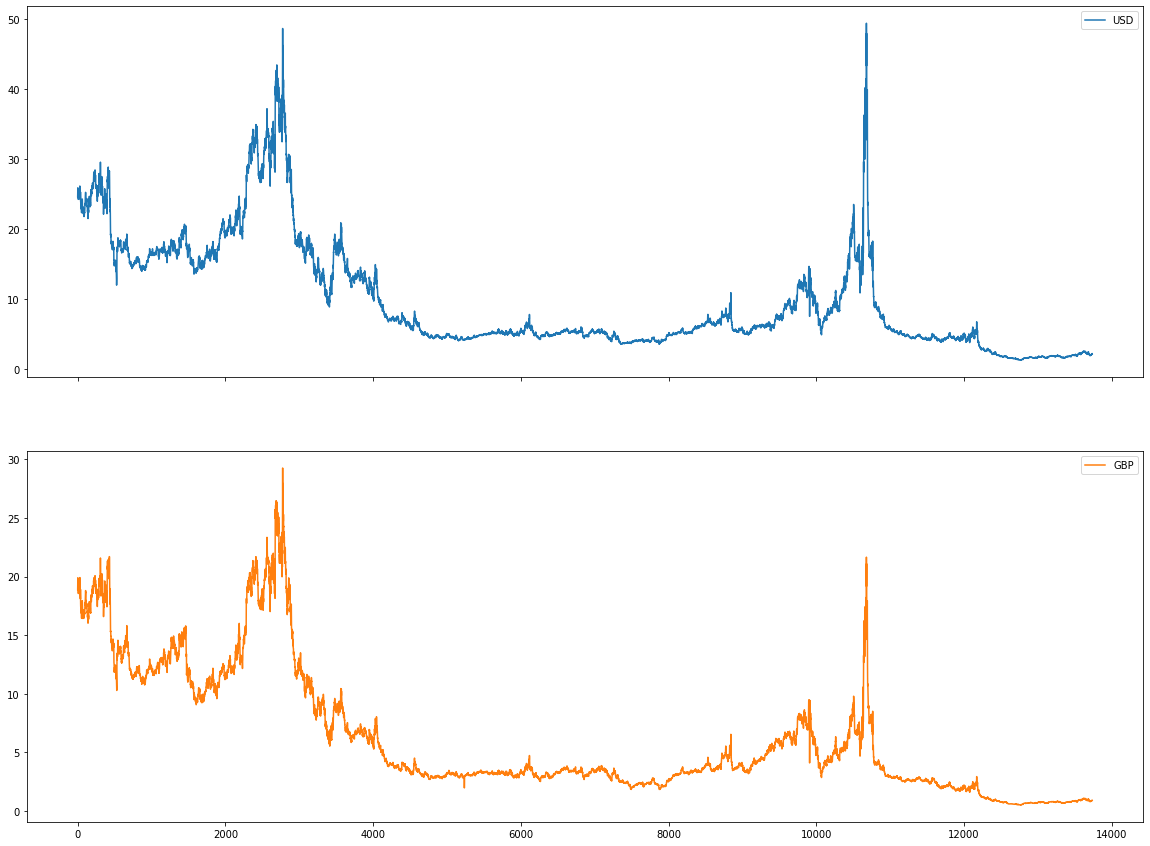

In [ ]:
df_plot = data_train
df_plot[df_plot.columns.to_list()].plot(subplots=True, figsize=(20, 15))
plt.show()

Date     object
USD     float64
GBP     float64
dtype: object

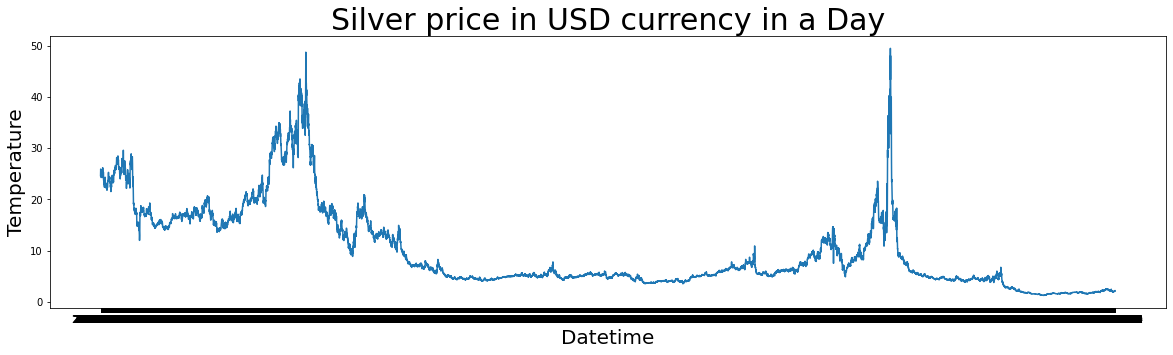

In [ ]:
dates = data_train['Date'].values
usd = data_train['USD'].values

dates = np.array(dates)
usd = np.array(usd)

plt.figure(figsize=(20,5))
plt.plot(dates, usd)

plt.title('Silver price in USD currency in a Day', fontsize = 30)
plt.ylabel('Temperature', fontsize = 20)
plt.xlabel('Datetime', fontsize = 20)

data_train.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


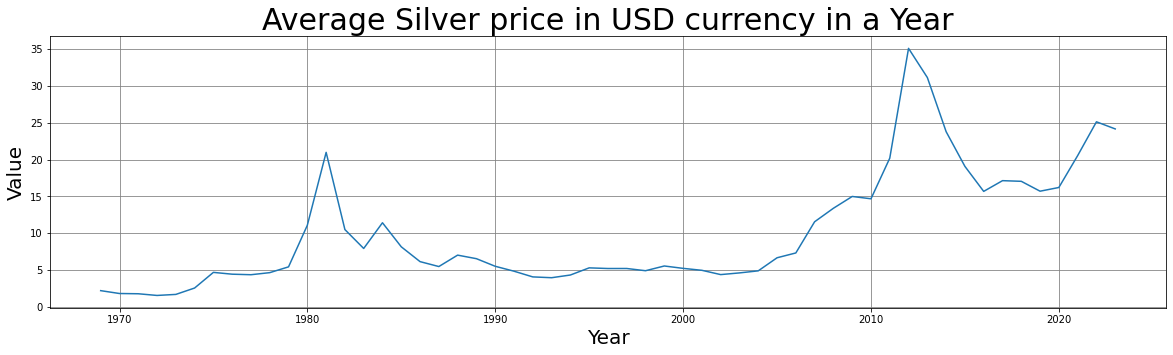

In [ ]:
data_train['Date'] = pd.to_datetime(data_train['Date'])
data_train = data_train.set_index('Date')

data_by_month = data_train.resample('A').mean()

time = data_by_month.index.values
test = data_by_month['USD'].values

plt.figure(figsize=(20,5))
plt.plot(time, test)
plt.title('Average Silver price in USD currency in a Year', fontsize = 30)
plt.ylabel('Value', fontsize = 20)
plt.xlabel('Year', fontsize = 20)
plt.grid(color='grey')

In [ ]:
usd = np.array(data_train['USD'])
usd = usd.reshape(-1, 1)

scaler = MinMaxScaler()
usd = scaler.fit_transform(usd)

In [ ]:
usd_train, usd_valid, dates_train, dates_valid = train_test_split(usd, dates, train_size=0.8, test_size = 0.2, shuffle = False )

In [ ]:
print('Total Data Train : ',len(usd_train))
print('Total Data Validation : ',len(dates_valid))

Total Data Train :  10973
Total Data Validation :  2744


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(usd_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(usd_valid, window_size=64, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 1]),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
threshold_mae = (usd.max() - usd.min()) * 10/100
print(threshold_mae)

0.1


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=300, validation_data = val_set, callbacks=[callbacks])

Epoch 1/300
55/55 [==============================] - 39s 638ms/step - loss: 0.0122 - mae: 0.1255 - val_loss: 0.0117 - val_mae: 0.1504
Epoch 2/300
55/55 [==============================] - 35s 623ms/step - loss: 0.0122 - mae: 0.1251 - val_loss: 0.0116 - val_mae: 0.1494
Epoch 3/300
55/55 [==============================] - 34s 622ms/step - loss: 0.0122 - mae: 0.1249 - val_loss: 0.0115 - val_mae: 0.1486
Epoch 4/300
55/55 [==============================] - 34s 620ms/step - loss: 0.0121 - mae: 0.1246 - val_loss: 0.0114 - val_mae: 0.1480
Epoch 5/300
55/55 [==============================] - 34s 620ms/step - loss: 0.0121 - mae: 0.1244 - val_loss: 0.0113 - val_mae: 0.1474
Epoch 6/300
55/55 [==============================] - 34s 622ms/step - loss: 0.0121 - mae: 0.1244 - val_loss: 0.0112 - val_mae: 0.1469
Epoch 7/300
55/55 [==============================] - 34s 615ms/step - loss: 0.0121 - mae: 0.1241 - val_loss: 0.0111 - val_mae: 0.1464
Epoch 8/300
55/55 [==============================] - 34s 616ms

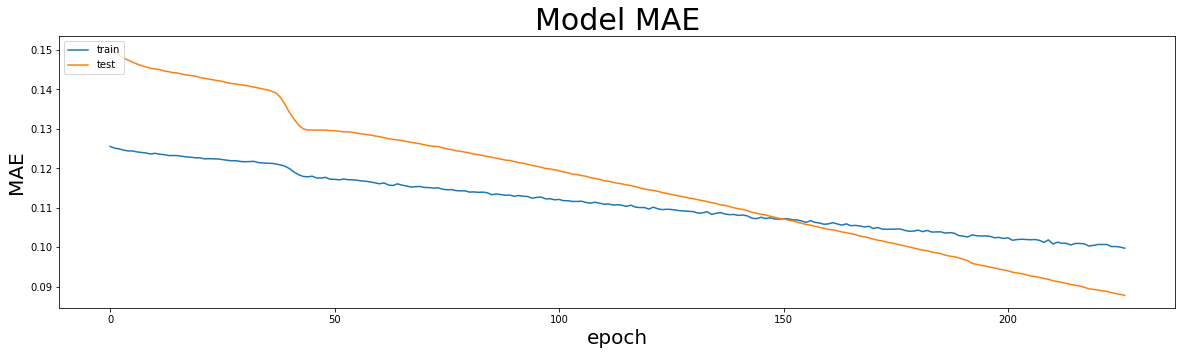

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE', fontsize=30)
plt.ylabel('MAE', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

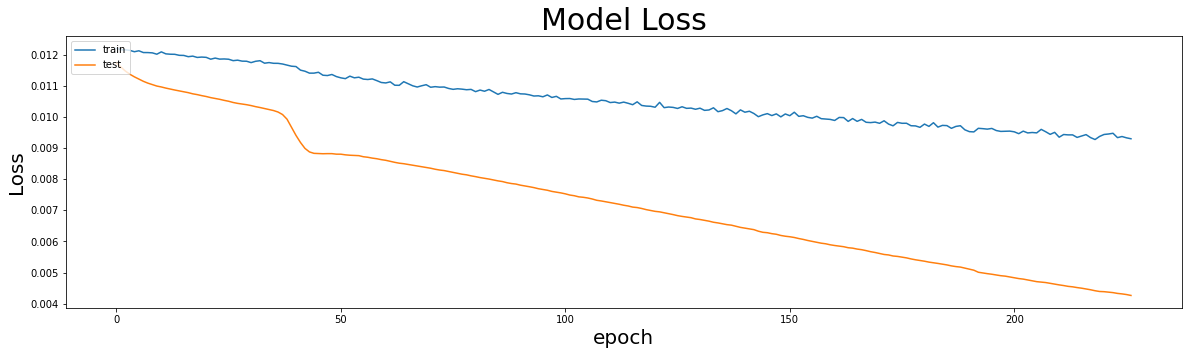

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=30)
plt.ylabel('Loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'test'], loc='upper left')
plt.show()